In [1]:
from ema_workbench import Scenario, Policy, MultiprocessingEvaluator, ema_logging, load_results, save_results
from ema_workbench.analysis import prim
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.analysis import parcoords
import seaborn as sns
import random
from sklearn import preprocessing

In [2]:
ACTORNAME = "Overijssel"
dike_model, planning_steps = get_model_for_problem_formulation(ACTORNAME)
outcomekeys = [outcome.name for outcome in dike_model.outcomes]

# Scenario selection

In [3]:
ACTOR = "genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz"
experiments, outcomes = load_results("data/generated/" + ACTOR)
outcomes_df = pd.DataFrame(outcomes)

In [4]:
outcomes_df.columns.values.tolist()

['Gorssel and Deventer Expected Annual Damage',
 'Gorssel and Deventer Expected Number of Deaths',
 'Gorssel and Deventer Total Costs']

In [5]:
DAMAGE = outcomes_df.columns[0]
DEATHS = outcomes_df.columns[1]
COSTS = outcomes_df.columns[2]

We are interested in the correlation between Deaths and Damage

In [6]:
outcomes_df[DAMAGE].corr(outcomes_df[DEATHS])

0.9757264909805828

So the correlation is INSANE

In [7]:
results = pd.concat([experiments, outcomes_df], axis=1)

In [8]:
uncertainties =list(dike_model.uncertainties._data.keys())

In [9]:
print(outcomes_df.idxmax())
print(outcomes_df.idxmin())

Gorssel and Deventer Expected Annual Damage         959
Gorssel and Deventer Expected Number of Deaths    35550
Gorssel and Deventer Total Costs                      0
dtype: int64
Gorssel and Deventer Expected Annual Damage       780
Gorssel and Deventer Expected Number of Deaths    780
Gorssel and Deventer Total Costs                    0
dtype: int64


In [10]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=23)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=27))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=23)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=27))]
twentyfive = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [11]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=48)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=52))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=48)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=52))]
fifty = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [12]:
middle_damage_df = results.loc[(results[DAMAGE] > np.percentile(a=outcomes[DAMAGE], q=73)) & (results[DAMAGE] <= np.percentile(a=outcomes[DAMAGE], q=77))]
middle_deaths_df = results.loc[(results[DEATHS] > np.percentile(a=outcomes[DEATHS], q=73)) & (results[DEATHS] <= np.percentile(a=outcomes[DEATHS], q=77))]
seventyfive = random.choice(list(set(middle_damage_df["scenario"].tolist()) & set(middle_deaths_df["scenario"].tolist())))

In [13]:
outcomes_df.loc[outcomes_df[DAMAGE] == outcomes_df.max()[0]]

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs
959,1.651202e+09,1.058792,0


In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
damage_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DAMAGE]).values)
deaths_scaled = min_max_scaler.fit_transform(pd.DataFrame(outcomes[DEATHS]).values)
scaled = (damage_scaled + deaths_scaled)/2

In [15]:
outcomes_df["Scaled"] = scaled
SCALED = 'Scaled'

In [16]:
outcomes_df.sort_values(by="Scaled", ascending=False).head(1).index[0]

959

Observation: Deventer more people die absolute worst
explanation: more densely populated

In [17]:
idx = [outcomes_df.idxmin()[DAMAGE], twentyfive, fifty, seventyfive, outcomes_df.idxmax()[DEATHS], outcomes_df.idxmax()[DAMAGE]]

In [18]:
idx

[780, 7306, 42180, 40712, 35550, 959]

In [19]:
cases = {0: "best", 1: "low", 2: "middle", 3: "high", 4: "worst deaths", 5: "absolute worst"}

In [20]:
selected = results.iloc[idx]

In [21]:
selected = selected.loc[:,  uncertainties]

In [22]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [23]:
outcomes_df.describe()

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths,Gorssel and Deventer Total Costs,Scaled
count,5.000000e+04,50000.000000,50000.0,50000.000000
mean,2.238156e+08,0.185281,0.0,0.152460
std,2.662215e+08,0.236627,0.0,0.187645
min,0.000000e+00,0.000000,0.0,0.000000
25%,6.118422e+07,0.036801,0.0,0.036152
50%,1.228096e+08,0.073162,0.0,0.074426
75%,2.556901e+08,0.219267,0.0,0.178319
max,1.651202e+09,1.093926,0.0,0.983941


# Optimisation

Based on the results in the above dataframe, epsilon values were chosen to be 1e+5 for Expected Damage, 0.01 for Expected Deaths, and 1e5 for Costs. This is to reflect the need for different levels of granularity for the three objectives. By choosing larger epsilon values where values are larger, it will lead to more meaningful solutions, and smaller epsilons where the values are smaller, we are able to trade off time for convergence with interesting and useful outcomes.

In [24]:
hypervolumemin = [0,0,0]
hypervolumemax = outcomes_df[outcomekeys].max(axis=0).values.tolist()

In [25]:
hypervolumemax[2] = 1.15e9

In [26]:
ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 5500 + 1000

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario, convergence_freq=200)
    return results, convergence


results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=hypervolumemin, maximum=hypervolumemax),
                           EpsilonProgress()]
    epsilons = [1e5, 0.01, 1e5]
    
    
    
    results.append(optimize(scenario, nfe, dike_model, convergence_metrics, epsilons))


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/6500 nfe
[MainProcess/INFO] generation 5: 498/6500 nfe
[MainProcess/INFO] generation 10: 993/6500 nfe
[MainProcess/INFO] generation 15: 1483/6500 nfe
[MainProcess/INFO] generation 20: 1939/6500 nfe
[MainProcess/INFO] generation 25: 2318/6500 nfe
[MainProcess/INFO] generation 30: 2680/6500 nfe
[MainProcess/INFO] generation 35: 3041/6500 nfe
[MainProcess/INFO] generation 40: 3428/6500 nfe
[MainProcess/INFO] generation 45: 3827/6500 nfe
[MainProcess/INFO] generation 50: 4225/6500 nfe
[MainProcess/INFO] generation 55: 4600/6500 nfe
[MainProcess/INFO] generation 60: 4992/6500 nfe
[MainProcess/INFO] generation 65: 5376/6500 nfe
[MainProcess/INFO] generation 70: 5769/6500 nfe
[MainProcess/INFO] generation 75: 6157/6500 nfe
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/6500 nfe
[MainProcess/INFO] generation 5: 5

In [27]:
results[0][1]

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.879935,4,100
2,0.950991,7,399
3,0.959437,8,698
4,0.991569,11,993
5,0.994504,12,1288
6,1.000000,13,1581
7,1.000000,13,1857
8,1.000000,13,2086
9,1.000000,13,2318


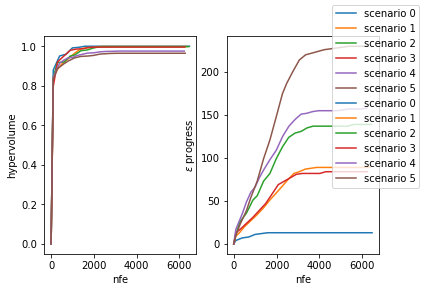

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2,sharex=True)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

# Saving

In [29]:
for i, (result, convergence) in enumerate(results):
    result.to_csv("data/optimisation/" + ACTORNAME + "/results_" + cases[i] +".csv", index=False)
    convergence.to_csv("data/optimisation/" + ACTORNAME + "/convergence_" + cases[i] +".csv", index=False)

In [30]:
selected.to_csv("data/optimisation/" + ACTORNAME + "/selected.csv", index=False)

# Re-evaluate under deep uncertainty

In [31]:
n_scenarios = 1000

In [32]:
levers = [lever.name for lever in dike_model.levers]

In [33]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:, levers]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {cases[i]} option {j}', **row.to_dict())
        policies.append(policy)

In [34]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reevaluation_results = evaluator.perform_experiments(n_scenarios, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 84 policies * 1 model(s) = 84000 experiments
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 16800 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 33600 cases completed
[MainProcess/INFO] 42000 cases completed
[MainProcess/INFO] 50400 cases completed
[MainProcess/INFO] 58800 cases completed
[MainProcess/INFO] 67200 cases completed
[MainProcess/INFO] 75600 cases completed
[MainProcess/INFO] 84000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# Saving

In [35]:
save_results(reevaluation_results, "data/optimisation/du_scen_" + str(n_scenarios) + "_" + ACTORNAME + ".tar.gz")

[MainProcess/INFO] results saved successfully to D:\juju\modelbaseddecisionmaking\FabiosDecisions\epa1361\final assignment\data\optimisation\du_scen_1000_Overijssel.tar.gz
